In [5]:
!pip install selectivesearch
!pip install torch_snippets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Import necessary libraries
from torch_snippets import logger, show
import selectivesearch
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset

In [8]:
# Define the root directory for images and load the raw data CSV
IMAGE_ROOT = '/content/drive/MyDrive/R-CNN data/images'
DF_RAW = pd.read_csv('/content/drive/MyDrive/R-CNN data/df.csv')
# Display the first few rows of the dataframe
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

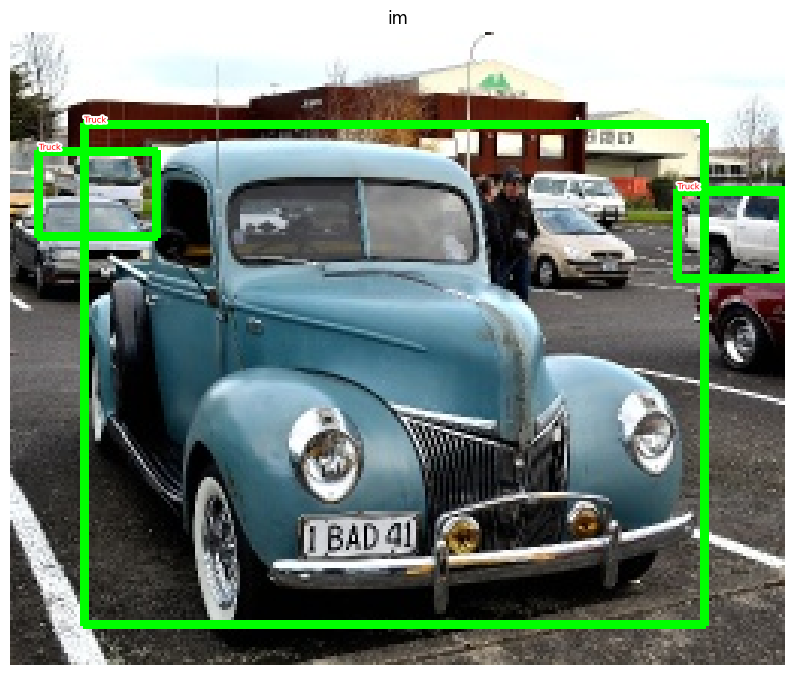

[[9, 39, 48, 67], [24, 30, 229, 195], [220, 52, 255, 81]]


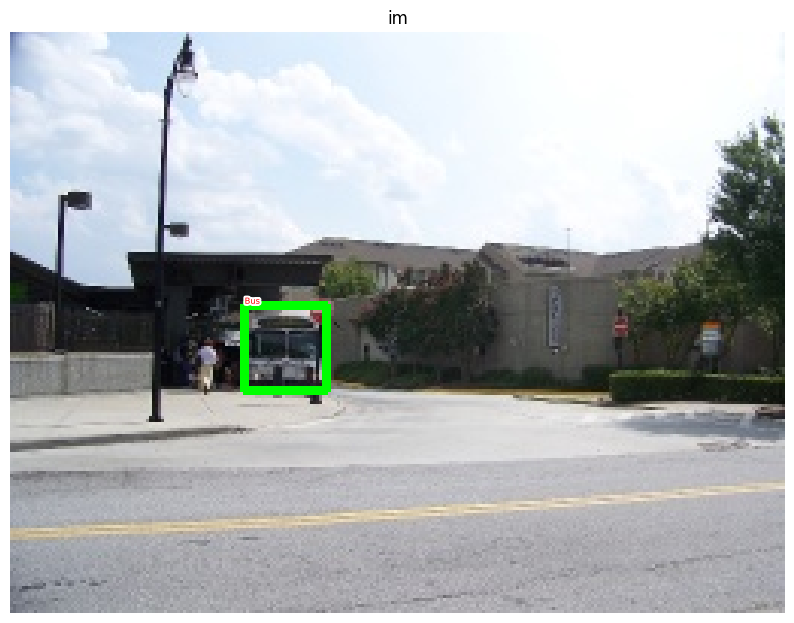

[[77, 90, 104, 118]]


In [9]:
# Define a custom dataset class for Open Images
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        # Get unique image IDs
        self.unique_images = df['ImageID'].unique()
    # Return the number of unique images
    def __len__(self): return len(self.unique_images)
    # Get an image and its bounding boxes, classes, and path by index
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        # Read image and convert from BGR to RGB
        image = cv2.imread(image_path, 1)[...,::-1]
        h, w, _ = image.shape
        df = self.df.copy()
        # Filter dataframe for the current image ID
        df = df[df['ImageID'] == image_id]
        # Extract bounding boxes and scale them to image dimensions
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #boxes in accordance to the image
        # Extract class labels
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

# Create an instance of the dataset
ds = OpenImages(df=DF_RAW)

# Display an example image with bounding boxes and labels
im, bbs, clss, _ = ds[6]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

# Display another example image with bounding boxes and labels
im, bbs, clss, _ = ds[15]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

In [10]:
# Function to extract candidate bounding boxes using selective search
def extract_candidates(img):
    # Perform selective search to get regions
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        # Skip duplicate regions
        if r['rect'] in candidates: continue
        # Skip regions that are too small
        if r['size'] < (0.05*img_area): continue
        # Skip regions that are too large
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        # Add the region's rectangle (x, y, w, h) to candidates
        candidates.append(list(r['rect']))
    return candidates

In [11]:
# Function to calculate Intersection over Union (IoU) of two bounding boxes
def extract_iou(boxA, boxB, epsilon=1e-5):
    # Determine the coordinates of the intersection rectangle
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    # Calculate the width and height of the intersection rectangle
    width = (x2 - x1)  #change in x-direction
    height = (y2 - y1)  #change in y-direction
    # If the intersection is empty, return 0.0
    if (width<0) or (height <0):
        return 0.0
    # Calculate the area of intersection
    area_overlap = width * height # this was calculated by x1, y1, x2, y2
    # Calculate the area of both bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    # Calculate the area of the union
    area_combined = area_a + area_b - area_overlap
    # Calculate IoU
    iou = area_overlap / (area_combined+epsilon)
    return iou

(38, 4)
<class 'list'>


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


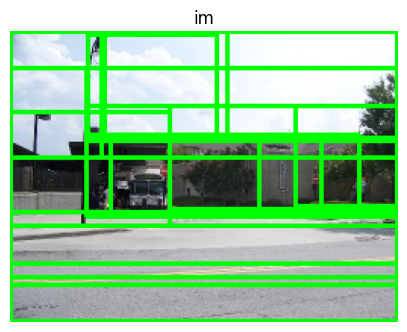

In [12]:
# Example of df[15]
candidates = extract_candidates(im)
# Convert [x, y, w, h] to [x1, y1, x2, y2] for all candidates
candidates_xyxy = [ [x, y, x+w, y+h] for x, y, w, h in candidates ]
print(np.shape(candidates_xyxy))
print(type(candidates_xyxy))
# Show the image with candidate bounding boxes
show(im, bbs = candidates_xyxy)

In [13]:
(im, bbs, labels, fpath) = ds[15]
H, W, _ = im.shape
# Extract candidate bounding boxes
candidates = extract_candidates(im)
# Convert candidates from [x, y, w, h] to [x1, y1, x2, y2] format
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])  # candidates extracted are the x,y,w,h way and made x1, y1, x2, y2 to be similar to the bbs in the dataset

# Initialize lists to store IoUs, ROIs, classes, deltas, and best IoUs
ious, rois, clss, deltas, best_ious = [], [], [], [], []
temp_best_bbs = []
# Calculate IoU between each candidate and each ground truth bounding box
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [14]:
# Iterate through each candidate bounding box
for jx, candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    # Get the IoU values for the current candidate against all ground truth boxes
    candidate_ious = ious[jx]  #ious for that candidate
    # Find the index of the best IoU for the current candidate
    best_iou_at = np.argmax(candidate_ious)  #best candidate iou is taken (index) ~ always be a zero index
    # Get the best IoU value
    best_iou = candidate_ious[best_iou_at]   #gets the best score here
    # Append the best IoU to the list
    best_ious.append(best_iou)
    # Get the ground truth bounding box corresponding to the best IoU
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # gets the target label bounding box where there is the highest iou
    # Append the best ground truth bounding box to a temporary list
    temp_best_bbs.append(best_bb)
    # Assign class label based on the best IoU
    if best_iou > 0.3: clss.append(labels[best_iou_at]) # if iou is more than 0.3 it is not the background
    else : clss.append('background')
    # Calculate delta (offset) between the candidate and the best ground truth box
    delta = np.array([_x-cx, _y-cy, _X-cY, _Y-cY]) / np.array([W,H,W,H])  #normalizing the delta based on image size
    # Append the delta to the list
    deltas.append(delta)
    # Append the normalized candidate bounding box (Region of Interest)
    rois.append(candidate / np.array([W,H,W,H]))

In [15]:
# Find the index of the overall best IoU among all candidates
best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])

# Get the candidate bounding box with the best IoU
best_candidate = candidates[best_ious_at]
# Get the ground truth bounding box corresponding to the overall best IoU
best_bbs = temp_best_bbs[best_ious_at]

Best IoU: 0.14555256036666817


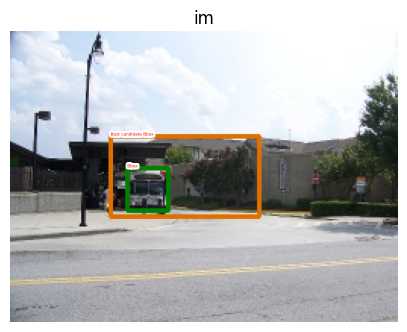

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [16]:
# Example of df[15]
candidates = extract_candidates(im)
# Show the image with the best ground truth bounding box and the best candidate bounding box
show(im, bbs = [best_bbs, best_candidate], confs= [0,0.5], texts = ['Bbox', 'Best candidate Bbox'])

# Initialize lists to store file paths, ground truth bounding boxes, classes, deltas, ROIs, and IoUs
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500 # Number of images to process
# Iterate through the dataset
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    # Break after processing N images
    if(ix==N):
        break
    H, W, _ = im.shape
    # Extract candidate bounding boxes
    candidates = extract_candidates(im)
    # Convert candidates from [x, y, w, h] to [x1, y1, x2, y2] format
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # Initialize lists for current image
    ious, rois, clss, deltas = [], [], [], []
    # Calculate IoU between each candidate and each ground truth bounding box for the current image
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    # Process each candidate for the current image
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        # Get the IoU values for the current candidate
        candidate_ious = ious[jx]
        # Find the index of the best IoU for the current candidate
        best_iou_at = np.argmax(candidate_ious)
        # Get the best IoU value
        best_iou = candidate_ious[best_iou_at]
        # Get the ground truth bounding box corresponding to the best IoU
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # Assign class label based on the best IoU
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        # Calculate delta (offset)
        delta = np.array([_x-cx, _y-cy, _X-cY, _Y-cY]) / np.array([W,H,W,H])
        # Append delta and normalized candidate (ROI)
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    # Append data for the current image to the overall lists
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

In [17]:
import os

# Adjust file paths to be absolute paths
FPATHS = [f'{IMAGE_ROOT}/{os.path.splitext(os.path.basename(f))[0]}.jpg' for f in FPATHS]
# Flatten the lists of lists (this line seems redundant, but keeping it as is)
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]] #?

In [18]:
from itertools import chain

# Function to flatten a list of lists
def flatten(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

# Create a DataFrame of flattened class labels
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
# Create dictionaries for label to target mapping and vice versa
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
# Get the target value for the 'background' class
background_class = label2target['background']

print("The label to target values dictionary formed is:" ,label2target)

# Define normalization transformation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Function to preprocess an image for the model
def preprocess_image(img):
    # Convert numpy array to torch tensor and change dimension order
    img = torch.tensor(img).permute(2,0,1)
    # Apply normalization
    img = normalize(img)
    # Move tensor to the specified device (GPU or CPU) and convert to float
    return img.to(device).float()
# Function to decode predicted class scores to class indices
def decode(_y):
    _, preds = _y.max(-1)
    return preds

The label to target values dictionary formed is: {'Bus': 0, 'background': 1, 'Truck': 2}


In [19]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    # Return the number of images in the dataset
    def __len__(self): return len(self.fpaths)
    # Get an item (image and associated data) by index
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        # Read image and convert from BGR to RGB
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        # Scale ROIs to image dimensions
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        # Extract image crops based on bounding boxes
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]  # bounding box image crops
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    # Custom collate function for creating batches
    def collate_fn(self, batch):
        '''Performing actions on a batch of images'''
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            # Resize crops to 224x224 and preprocess them
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            # Extend lists with batch data
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        # Concatenate inputs, labels, and deltas into tensors
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [20]:
import torch
import torch.nn as nn

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained VGG16 model
vgg_backbone = models.vgg16(pretrained=True)
# Remove the classifier layer
vgg_backbone.classifier = nn.Sequential()
# Freeze the parameters of the backbone
for param in vgg_backbone.parameters():
    param.requires_grad = False #not to do a re-train
# Set the backbone to evaluation mode and move to the device
vgg_backbone.eval().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 84.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the feature dimension from the backbone
        feature_dim = 25088
        # Assign the VGG backbone
        self.backbone = vgg_backbone
        # Define the classification head
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        # Define the bounding box regression head
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        # Define the loss functions
        self.cel = nn.CrossEntropyLoss() # loss for classification
        self.sl1 = nn.L1Loss() # loss for regression
    # Define the forward pass
    def forward(self, input):
        # Pass input through the backbone
        feat = self.backbone(input)  # both classification and regression takes 'feat' as input
        # Get classification scores and bounding box deltas
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    # Function to calculate the total loss
    def calc_loss(self, probs, _deltas, labels, deltas):
        # probs is basically the predicted class
        # Calculate classification loss
        detection_loss = self.cel(probs, labels)
        # Get indices of non-background labels
        ixs, = torch.where(labels != 1) #removing the label 1, which is background
        # Filter predicted and ground truth deltas for non-background labels
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        # Define the lambda parameter for balancing losses
        self.lmb = 10.0
        # Calculate regression loss only for non-background labels
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            # Return total loss, classification loss, and regression loss
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            # every ix is detected as background
            regression_loss = 0
            # Return only classification loss if no non-background labels are present
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [22]:
# Function to train the model on a single batch
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    # Set model to training mode
    model.train()
    # Zero the gradients
    optimizer.zero_grad()
    # Get predictions from the model
    _clss, _deltas = model(input)  # as model outputs we will be getting classes and delta (bbox offsets)
    # Calculate the loss
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    # Calculate accuracy
    accs = clss == decode(_clss)
    # Perform backpropagation
    loss.backward()
    # Update model weights
    optimizer.step()
    # Return detached loss values and accuracies
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [23]:
@torch.no_grad()
# Function to validate the model on a single batch
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        # Set model to evaluation mode
        model.eval()
        # Get predictions from the model
        _clss,_deltas = model(input)
        # Calculate the loss
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        # Get predicted class indices
        _, _clss = _clss.max(-1)  # more like a softmax np argmax
        # Calculate accuracy
        accs = clss == _clss
    # Return predictions, detached loss values, and accuracies
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [24]:
import torch.optim as optim

# Initialize the R-CNN model and move it to the device
rcnn = RCNN().to(device)
# Define the criterion (loss function)
criterion = rcnn.calc_loss
# Define the optimizer
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
# Set the number of training epochs
n_epochs = 5

# Simple logging with lists
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [25]:
from torch.utils.data import DataLoader, random_split

# Create the RCNNDataset
rcnn_dataset = RCNNDataset(FPATHS, ROIS, CLSS, DELTAS, GTBBS)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(rcnn_dataset))
test_size = len(rcnn_dataset) - train_size
train_dataset, test_dataset = random_split(rcnn_dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=rcnn_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=rcnn_dataset.collate_fn)

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 400
Testing set size: 100


/tmp/ipython-input-274761901.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  deltas = torch.Tensor(deltas).float().to(device)


Epoch 1/5 - Val [100/100] - Loss: 2.8970 - Acc: 0.8431
Epoch 1/5 Summary:
Train Loss: 2.0803 - Train Acc: 0.7345
Val Loss: 1.4874 - Val Acc: 0.8248
--------------------------------------------------
Epoch 2/5 - Val [100/100] - Loss: 2.8879 - Acc: 0.7059
Epoch 2/5 Summary:
Train Loss: 1.2916 - Train Acc: 0.8817
Val Loss: 1.4763 - Val Acc: 0.8169
--------------------------------------------------
Epoch 3/5 - Val [100/100] - Loss: 2.7640 - Acc: 0.8627
Epoch 3/5 Summary:
Train Loss: 0.9548 - Train Acc: 0.9426
Val Loss: 1.4197 - Val Acc: 0.8156
--------------------------------------------------
Epoch 4/5 - Val [100/100] - Loss: 2.7877 - Acc: 0.8431
Epoch 4/5 Summary:
Train Loss: 0.8152 - Train Acc: 0.9653
Val Loss: 1.4174 - Val Acc: 0.8230
--------------------------------------------------
Epoch 5/5 - Val [100/100] - Loss: 2.7677 - Acc: 0.8627
Epoch 5/5 Summary:
Train Loss: 0.7235 - Train Acc: 0.9744
Val Loss: 1.3999 - Val Acc: 0.8247
--------------------------------------------------


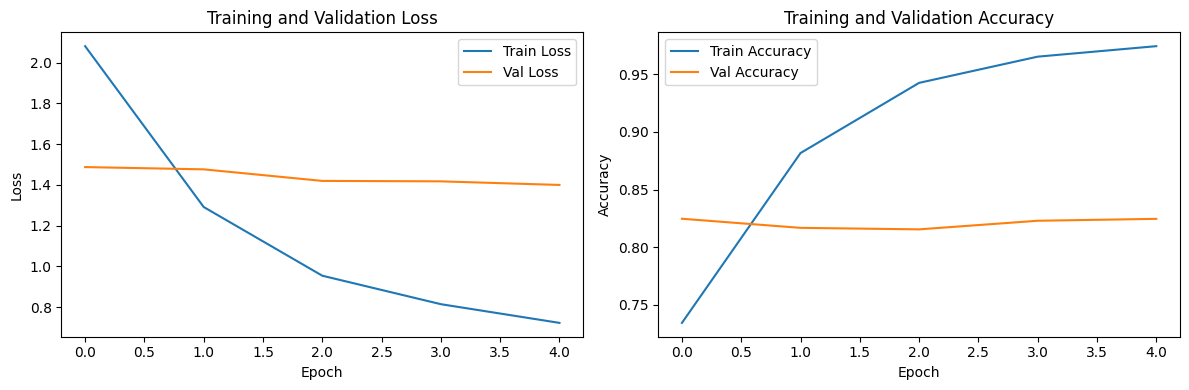

In [26]:
# loc_loss: loss on classification
# regr_loss: loss on regression

# Loop through epochs
for epoch in range(n_epochs):
    # Training phase
    epoch_train_losses = []
    epoch_train_accs = []

    _n = len(train_loader)
    # Iterate through training data loader
    for ix, inputs in enumerate(train_loader):
        # Train the batch
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        # Store training metrics
        epoch_train_losses.append(loss.item())
        epoch_train_accs.append(accs.mean())

        # Print progress
        print(f'\rEpoch {epoch+1}/{n_epochs} - Train [{ix+1}/{_n}] - Loss: {loss.item():.4f} - Acc: {accs.mean():.4f}', end='')

    # Validation phase
    epoch_val_losses = []
    epoch_val_accs = []

    _n = len(test_loader)
    # Iterate through validation data loader
    for ix, inputs in enumerate(test_loader):
        # Validate the batch
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        # Store validation metrics
        epoch_val_losses.append(loss.item())
        epoch_val_accs.append(accs.mean())

        # Print progress
        print(f'\rEpoch {epoch+1}/{n_epochs} - Val [{ix+1}/{_n}] - Loss: {loss.item():.4f} - Acc: {accs.mean():.4f}', end='')

    # Store epoch averages
    train_losses.append(np.mean(epoch_train_losses))
    train_accs.append(np.mean(epoch_train_accs))
    val_losses.append(np.mean(epoch_val_losses))
    val_accs.append(np.mean(epoch_val_accs))

    # Print epoch summary
    print(f'\nEpoch {epoch+1}/{n_epochs} Summary:')
    print(f'Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accs[-1]:.4f}')
    print(f'Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_accs[-1]:.4f}')
    print('-' * 50)

# Plotting training and validation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Function to test the model on a given image
def test_predictions(filename, show_output=True):
    # Read the image and convert from BGR to RGB
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    # Extract candidate bounding boxes
    candidates = extract_candidates(img)
    # Convert candidates from [x, y, w, h] to [x1, y1, x2, y2] format
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    # Process each candidate crop
    for candidate in candidates:
        x,y,X,Y = candidate
        # Resize and preprocess the crop
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    # Concatenate processed crops into a tensor
    input = torch.cat(input).to(device)  #Concatenates the given sequence of seq tensors in the given dimension
    with torch.no_grad():
        # Set model to evaluation mode
        rcnn.eval()
        # Get predictions (probabilities and deltas) from the model
        probs, deltas = rcnn(input)
        print("Shape of probs", np.shape(probs))
        print("Shape of deltas", np.shape(deltas))
        # Apply softmax to get probabilities
        probs = torch.nn.functional.softmax(probs, -1)  # probability is put between 0 and 1 by doing a softmax
        # Get confidence scores and predicted class indices
        confs, clss = torch.max(probs, -1) #-1 is the dimension in which the max (reduction) must happen -> confs tells me the confidence and clss tells me the class where it has found the max probs
        print("Shape of confs", np.shape(confs))
        print("Shape of clss", np.shape(clss))
    # Convert tensors to numpy arrays
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    # Filter out background predictions
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    # Apply deltas to candidate bounding boxes to get final bounding boxes
    bbs = (candidates + deltas).astype(np.uint16)
    # Apply Non-Maximum Suppression (NMS) to filter overlapping bounding boxes
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    # Handle case where only one bounding box remains after NMS
    if len(ixs) == 1:
        # condition that even after nms, many ixs come for the bbox
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    # If no bounding boxes are detected and show_output is False, return default values
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    # If bounding boxes are detected
    if len(confs) > 0:
        # Find the bounding box with the highest confidence
        best_pred = np.argmax(confs)  # index
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    # Plot the original image and the predicted bounding boxes
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    # If no bounding boxes are detected, show a message
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    # Show the image with predicted bounding boxes and labels
    ax[1].set_title('Predicted object: ' + target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()
    # Return the best bounding box, predicted class, and confidence
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Shape of probs torch.Size([29, 3])
Shape of deltas torch.Size([29, 4])
Shape of confs torch.Size([29])
Shape of clss torch.Size([29])


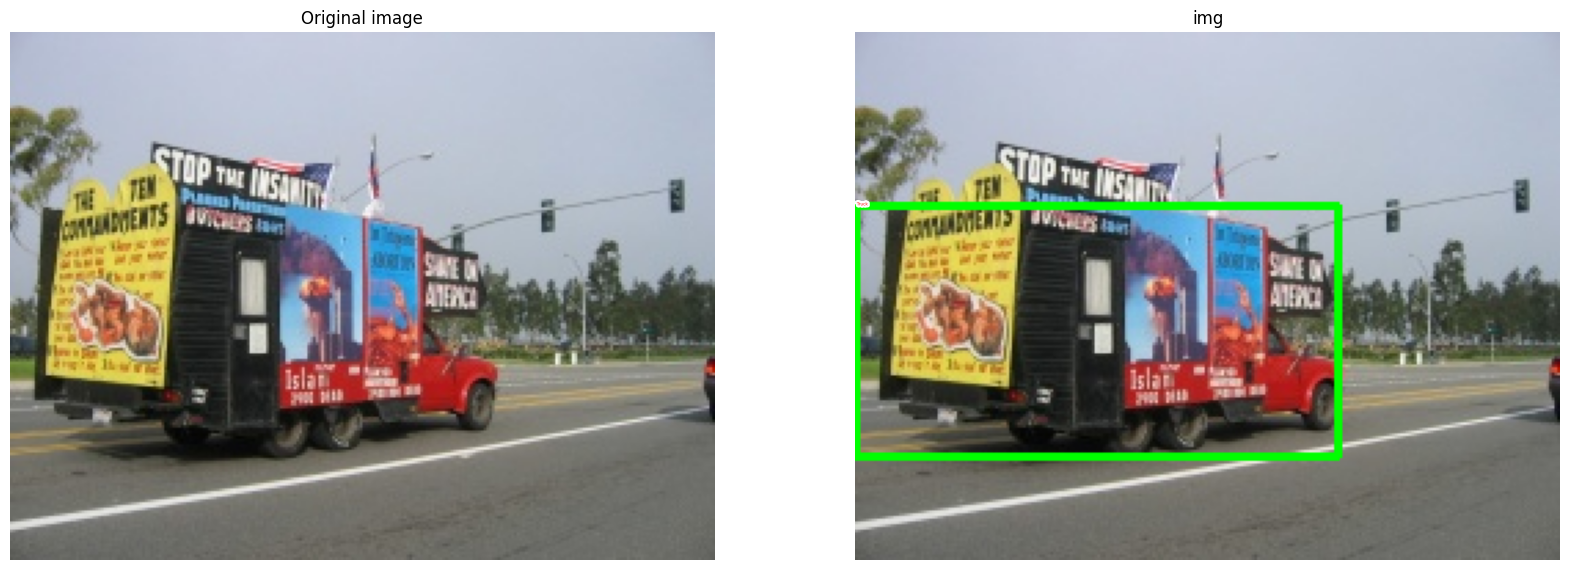

((np.uint16(0), np.uint16(63), np.uint16(175), np.uint16(154)),
 'Truck',
 np.float32(0.9943136))

In [28]:
# Get an example image and its data from the test dataset
image, crops, bbs, labels, deltas, gtbbs, fpath = test_dataset[1]
# Test the model on the example image
test_predictions(fpath)